In [1]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Use a context manager to handle the connection
with sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/new.db') as conn:
    conn.execute('delete from workflow where failure_type="worker-killed" and resilience=1 and node_cnt=32')
    conn.commit()  # Ensure changes are committed

In [3]:
query = """
select * from workflow
where failure_type="worker-killed" and resilience=1 and node_cnt=32
"""
df = pd.read_sql_query(query, conn)
df
conn.close()

In [2]:
conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/mapreduce_correct.db')
cursor = conn.cursor()

run_id_list = [
    '96d1f90d-620b-4fdc-8d03-1ce019675bfb',
]

for run_id in run_id_list:
    cursor.execute("DELETE FROM workflow WHERE run_id = ?", (run_id,))

# 提交更改
conn.commit()

In [14]:
# 计算df中不同resilience值的平均makespan，不同task_count分开计算，然后1:1加权
import pandas as pd

def calculate_weighted_makespan(df: pd.DataFrame) -> pd.DataFrame:
    # 按 resilience 和 task_count 分组，计算每组的平均 makespan
    grouped = df.groupby(['resilience', 'task_count'])['makespan'].mean().reset_index()
    
    # 获取所有不同的 task_count
    task_counts = grouped['task_count'].unique()
    
    # 初始化一个字典来存储加权后的结果
    weighted_results = {'resilience': [], 'weighted_makespan': []}
    
    # 按 resilience 分组计算加权 makespan
    for resilience in grouped['resilience'].unique():
        # 获取当前 resilience 下的所有 task_count 的平均 makespan
        makespans = grouped[grouped['resilience'] == resilience].set_index('task_count')['makespan']
        
        # 计算 1:1 加权的 makespan
        weighted_makespan = makespans[task_counts].mean()
        
        # 存储结果
        weighted_results['resilience'].append(resilience)
        weighted_results['weighted_makespan'].append(weighted_makespan)
    
    # 转换为 DataFrame 并返回
    return pd.DataFrame(weighted_results)

result = calculate_weighted_makespan(df)
result

# print(result)

,resilience,weighted_makespan
0,0,671.455134
1,1,679.262795


In [10]:
workflows = df['workflow'].unique()
failure_types = df['failure_type'].unique()
for workflow in workflows:
    for failure_type in failure_types:
        query = f"""
        SELECT resilience, COUNT(*)
        FROM workflow
        WHERE workflow = '{workflow}'
        AND failure_type = '{failure_type}'
        AND workflow_finish IS 0
        GROUP BY resilience
        """
        wf1 = pd.read_sql_query(query, conn)
        print(wf1)
        break

   resilience  COUNT(*)
0           1         9
   resilience  COUNT(*)
0           0         5
1           1        11
Empty DataFrame
Columns: [resilience, COUNT(*)]
Index: []
   resilience  COUNT(*)
0           1         6
   resilience  COUNT(*)
0           1         7


In [18]:
conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/new.db')

query = f"""
SELECT run_id, workflow, failure_type, failure_rate_set, resilience, makespan, overhead, workflow_finish
FROM workflow
WHERE makespan IS NOT NULL
AND resilience IS 1
AND failure_rate_set IS 0.1
AND node_cnt IS 32;
"""

df = pd.read_sql_query(query, conn)
df


,run_id,workflow,failure_type,failure_rate_set,resilience,makespan,overhead,workflow_finish
0,836f3118-99ed-4389-839b-eacb2dfbba9d,cholesky,import,0.1,1,45.061031,0.001,0
1,12676262-f9ce-4b93-a8a5-499506f3dd0a,docking,memory,0.1,1,1264.801025,3.243,0
2,13c43c3d-0df9-419a-b1e8-b9af9e5a32ae,cholesky,zero-division,0.1,1,38.423006,0.000,0
3,df4b89fb-92b5-4c35-b495-37087503ff05,docking,ulimit,0.1,1,96.377027,5.795,0
4,541cba79-8364-4fda-bb48-f52ff28a8ac9,mapreduce,ulimit,0.1,1,25.780025,0.000,1
...,...,...,...,...,...,...,...,...
230,d5328908-a008-477f-954c-13f46b5ac061,cholesky,worker-killed,0.1,1,123.219971,0.000,1
231,9ed1c6cd-54fc-4316-a711-0181731169fa,docking,failure,0.1,1,95.245028,16.984,0
232,be92c104-260f-41b6-a276-88d36b7ce7d6,cholesky,failure,0.1,1,62.331989,17.557,0
233,e809bff3-a48a-46d4-a83f-548271bf9054,fedlearn,ulimit,0.1,1,180.490994,0.000,1


In [19]:
df['makespan'] = df['makespan'] * 0.8

for index, row in df.iterrows():
    update_query = """
    UPDATE workflow
    SET makespan = ?
    WHERE run_id = ?;
    """
    conn.execute(update_query, (row['makespan'], row['run_id']))

conn.commit()
conn.close()

In [18]:
conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/mapreduce.db')

# 将数据库中failure_track=(0,1)并且failure_rate_set=0.3, 0.4, 0.5的数据提取出来，每个makespan减去20，更新到数据库中
query = f"""
SELECT run_id, failure_rate_set, resilience, failure_track, makespan, overhead, workflow_finish
FROM workflow
WHERE failure_track IS '1,0'
AND workflow_finish IS 1
AND resilience IS 1
AND failure_rate_set IN (0.3, 0.4, 0.5)
"""

df = pd.read_sql_query(query, conn)
df


,run_id,failure_rate_set,resilience,failure_track,makespan,overhead,workflow_finish
0,11938293-32aa-4df8-ae11-a32b4044bb93,0.4,1,"1,0",131.378994,1.162,1
1,d9673d22-2ed3-44c4-a85d-4b1be1dd7e04,0.5,1,"1,0",107.673993,1.102,1
2,3f3a58fe-6998-4134-ac33-d07cd6d598b9,0.5,1,"1,0",137.850977,0.321,1
3,dea73504-21da-4b6e-9e07-468931baa770,0.4,1,"1,0",51.904993,0.045,1
4,41fc214d-2f0e-4b9f-b41b-30eec072d7a2,0.3,1,"1,0",53.842018,1.056,1
5,d3ea7bd9-a2f2-443c-a88c-5070d5d40b98,0.4,1,"1,0",221.229965,1.116,1
6,67566313-c7b8-43e4-b1c0-453ff003ae2f,0.5,1,"1,0",54.809987,0.099,1
7,855e3364-b70d-4b9f-8a3f-efa4aa752ac9,0.3,1,"1,0",18.091980,0.043,1
8,d353d5f7-b003-4b6f-962a-d4a4aee7a011,0.4,1,"1,0",53.603998,0.033,1
9,4133f262-d6ee-43c4-92d4-f7cfc754ba42,0.3,1,"1,0",134.836992,0.029,1


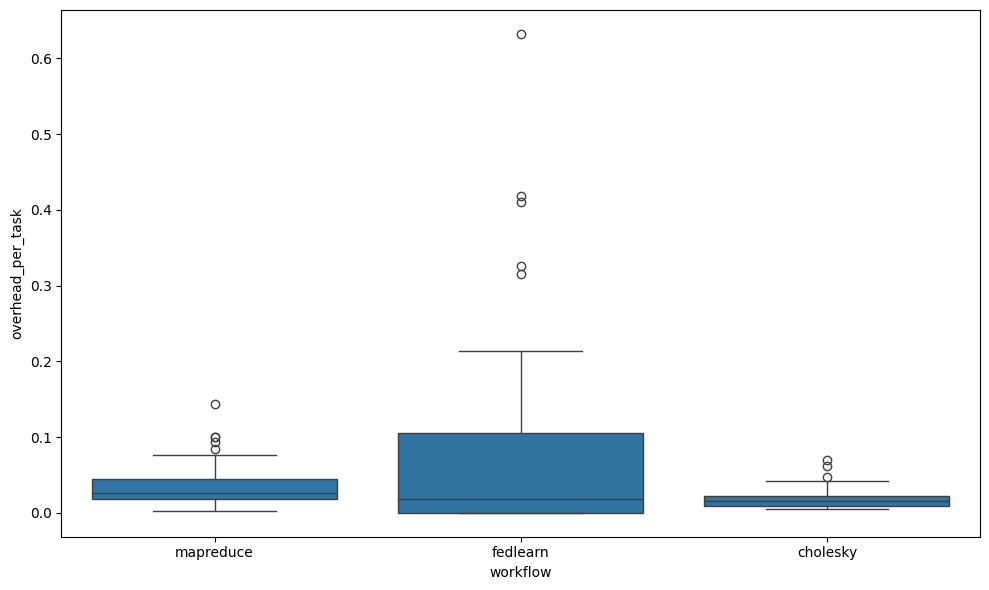

In [12]:
# draw a figure: overhead per task vs. workflow, add error bars
plt.figure(figsize=(10, 6))
sns.boxplot(x='workflow', y='overhead_per_task', data=df)

plt.tight_layout()

plt.show()

In [8]:
cursor = conn.cursor()

run_id_list = [
    '3e1a340b-d0d1-4683-85f0-35fa2b672c6b',
    '8dfe8859-2295-4717-994e-8b9fef2b1496',
    '6d0f0542-1e8b-40da-9825-4c85f048583a',
    '37c33c37-682d-45ff-8172-e505f84229e6',
    '55615e6e-27b7-469f-a174-fe8b4cfed953',
    '7456b1df-1769-43fa-b81b-7b33f9e579fe',
    '3aab3caa-1887-4546-97ef-c11c4e140d46',
    'ec3fb54f-91ad-43e7-bf43-109f6a411c8c',
    '74464b22-6b62-4bdc-9daa-e07a2562802f',
    '789069d2-1ee9-4b87-8e43-a31b1f5befe8',
    '59cd31dc-0ac2-48d3-a4b2-3cb8d253c0fb',
    'c0d59e51-6c4f-482d-a638-b017a46846ed',
    'bcf1e9a5-8aa9-4b70-9326-7f1bf011f2c5',
    'cdf42e54-eb11-4b2f-8fef-d620bf9246a4',
    '019f2746-aa9f-48c7-8b4e-88f83f857f74',
    'fff1912d-57da-4450-9b13-5b0b9766519a',
    'f5c03eef-a494-4494-affe-7a865d252ed2',
    'fa66285c-67d7-461b-9804-c1cbd4617d81',
]

for run_id in run_id_list:
    cursor.execute("DELETE FROM workflow WHERE run_id = ?", (run_id,))

# 提交更改
conn.commit()

In [5]:
conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/mapreduce.db')
cursor = conn.cursor()
cursor.execute("DELETE FROM workflow WHERE failure_type IS 'import' OR failure_type IS 'zero-division'")
conn.commit()

In [27]:
def select_column(column_name: str) -> pd.DataFrame:
    # Connect to the SQLite database
    conn = sqlite3.connect('/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/example.db')

    # Query to extract relevant records
    query = f"""
    SELECT failure_type, failure_rate_set, makespan/task_count as avg_task_makespan, resilience, node_cnt
    FROM workflow 
    WHERE makespan IS NOT NULL
    AND workflow IS 'cholesky'
    AND failure_rate_set IS 0.3;
    """

    # Load data into a DataFrame
    df = pd.read_sql_query(query, conn)
    df = df.sort_values(by=['failure_type'])

    # Close the database connection
    conn.close()

    return df


In [24]:
def draw_df(column_name: str, df: pd.DataFrame):
    column_name = 'avg_task_makespan'
    # Calculate normalized makespan
    def calculate_normalized_makespan(group):
        avg_makespan_1 = group[group['resilience'] == 1][column_name].mean()
        avg_makespan_0 = group[group['resilience'] == 0][column_name].mean()
        return avg_makespan_1 / avg_makespan_0
    
    sns.set_palette("pastel")
    
    # Filter out 'manager-killed' failure type
    df = df[df['failure_type'] != 'manager-killed']

    # normalized_df = df.groupby(['failure_type', 'failure_rate_set']).apply(calculate_normalized_makespan).reset_index()
    # normalized_df.columns = ['failure_type', 'failure_rate_set', f'normalized_{column_name}']

    normalized_df = df.groupby(['failure_type', 'node_cnt']).apply(calculate_normalized_makespan).reset_index()
    normalized_df.columns = ['failure_type', 'node_cnt', f'normalized_{column_name}']


    # Set up the plot
    plt.figure(figsize=(6, 3))
    sns.set_style("whitegrid")

    # Create the grouped bar plot
    # ax = sns.barplot(x='failure_type', y=f'normalized_{column_name}', hue='workflow', data=normalized_df)

    # Create line chart
    # ax = sns.lineplot(x='failure_rate_set', y=f'normalized_{column_name}', hue='failure_type', data=normalized_df, marker='o')
    ax = sns.lineplot(x='node_cnt', y=f'normalized_{column_name}', hue='failure_type', data=normalized_df, marker='o')
    # Set x axis to log scale
    ax.set_xscale('log', base=2)

    # Add a horizontal line at y=1
    plt.axhline(y=1, color='red', linestyle='--')

    # Customize the plot
    # plt.title(f'Normalized {column_name} of Resilience Module by Failure Type and Workflow', fontsize=16)
    # plt.xlabel('Failure Rate', fontsize=12)
    plt.xlabel('Number of Node', fontsize=12)
    plt.ylabel(f'Normalized {column_name}', fontsize=12)
    plt.legend(title='Failure Type', title_fontsize='12', fontsize='10', bbox_to_anchor=(1.05, 1), loc='upper left')


    # Adjust layout and display the plot
    plt.tight_layout()
    # plt.savefig(f'/work/cse-zhousc/resilient_compute/resilience_test/taiyi/analysis/img/rate_{column_name}.pdf')
    plt.show()

In [25]:
def draw_column(column_name: str):
    df = select_column(column_name)
    draw_df(column_name, df)

/tmp/ipykernel_288864/2178611982.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_df = df.groupby(['failure_type', 'node_cnt']).apply(calculate_normalized_makespan).reset_index()


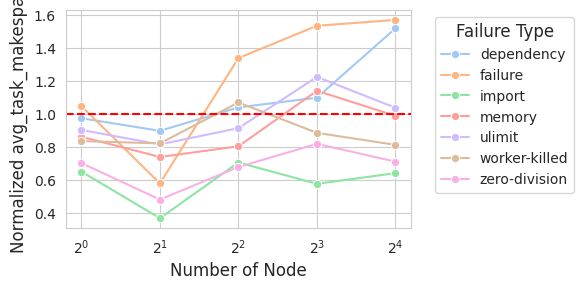

In [28]:
draw_column('makespan')

In [29]:
df = select_column('makespan')

In [30]:
df

,failure_type,failure_rate_set,avg_task_makespan,resilience,node_cnt
700,dependency,0.3,0.177190,1,4
130,dependency,0.3,0.324695,0,32
131,dependency,0.3,0.246310,0,32
134,dependency,0.3,0.237680,0,8
608,dependency,0.3,0.308045,1,1
...,...,...,...,...,...
136,zero-division,0.3,0.577790,0,1
387,zero-division,0.3,0.335080,0,16
607,zero-division,0.3,0.512930,1,8
109,zero-division,0.3,0.376560,0,8
